## retagImg
A notebook to pull in tags from a pretagged repository, run a function against them (in this case Computer Vision to get dominate color) and write the new tags back to the original repository.


In [1]:
# install packages if needed
import sys
!{sys.executable} -m pip install azure-cognitiveservices-vision-customvision
!{sys.executable} -m pip install azureml-sdk
!{sys.executable} -m pip install azureml-contrib-dataset
!{sys.executable} -m pip install azure-storage-blob
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install scipy

3.0,>=1.2.0->azureml-dataprep[fuse]<1.6.0a,>=1.4.10a->azureml-sdk) (1.3.0)


In [ ]:
## Steps per notebook cell
* pip requirements.txt
* imports
* custom user defined variables
* for... each image in repository
    * convert URL into document 
    * possibly convert from % to actual pixel counts
    * for... each tag1 in image
        * read dimentions, if it is less than 50 pixels expand both sides by 1 until it is at least 50x50
        * snip that byte stream send to "Computer Vision"
        * retrieve dominate color, add tag2 with color to image, and add tag1 " - " tag2 to image
        * write back to repository
* close out everything 
    


In [1]:
# From Laurens Ariel Import
import json, os, shutil
import azureml.contrib.dataset

from azureml.core import Workspace, Dataset, Datastore
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
# azureml-contrib-dataset of version 1.0.72 or higher is required

In [2]:
# From Laurens Ariel Import
subscription_id = '2fe7f70e-ab59-4d15-b475-b417edd1a5a3'
resource_group = 'ckahrsMantechRG'
workspace_name = 'ckahrsMantechAMLWS'
dataset_name = 'LabelSatImages-2020-05-19 13:53:25'

ws = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(ws, name=dataset_name)
df = dataset.to_pandas_dataframe()

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [10]:
# df['label'][0][0]
# df
blob_datastore


{
  "name": "satimages",
  "container_name": "satimages",
  "account_name": "ckahrsmantechstorage",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [19]:
df.to_json("finaldata2.jsonl", orient="records", lines=True)

In [26]:
# write back a file to the same workspace

df.to_csv('dataset.csv')
blob_datastore.upload(src_dir='../', target_path='../')
dataset_updated = Dataset.Tabular.from_delimited_files(blob_datastore.path('../dataset.csv'))


NameError: name 'blob_datastore' is not defined

In [ ]:
dataset_updated = dataset_updated.register(workspace = ws,
                                 name = dataset_name,
                                 description = 'updated dataset',
                                 create_new_version = True)

In [6]:
df['label'][0][0]

{'label': 'car',
 'topX': 0.6823267527445109,
 'topY': 0.3955398224547,
 'bottomX': 0.7242072251980414,
 'bottomY': 0.41425239730499935}

In [7]:
# hack to extract datastore name - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
s = str(df.iloc[0].image_url) 
s = s.split('[')[1].split(']')[0]
s = s.replace("'", "\"") 
ds = json.loads(s)['datastoreName']

# get datastore
blob_datastore = Datastore.get(ws, ds)

# create temp directory for labeled dataset download
tmp_dir = '../tmp'
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# hack to extract path - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
df['path_to_download'] = df['image_url'].apply(lambda x: str(x).split('//')[1].split("[")[0])

In [29]:
df.loc[0, "path_to_download"]

'coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_100.jpg'

In [8]:
df['label'][0][0]['topX']

0.6823267527445109

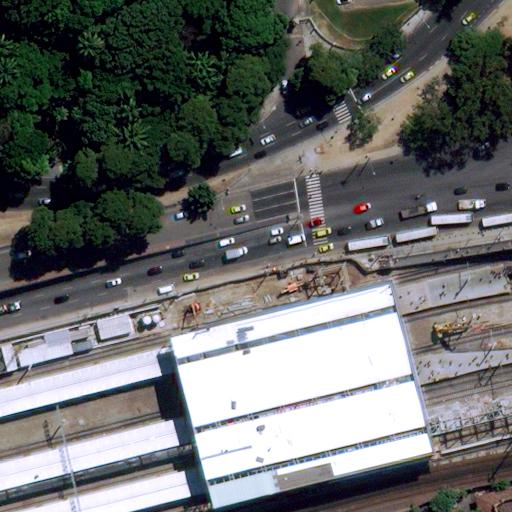

(512, 512)


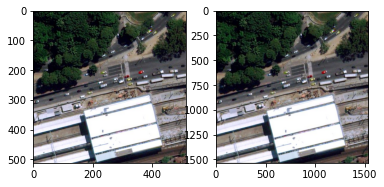

(1536, 1536)
1048
607
1112
636
Start enoughx: 64
End enoughx: 64
Start enoughy: 29
End enoughy: 51


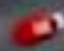

(64, 51)

In [22]:

from azureml.contrib.dataset import FileHandlingOption


#satimg_pd = dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download/', overwrite_download=True)

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# #read images from downloaded path
# img = mpimg.imread(satimg_pd.loc[0,'image_url'])
# imgplot = plt.imshow(img)
from PIL import Image, ImageDraw
import numpy as np

im = Image.open(satimg_pd.loc[0,'image_url'])
im2  = Image.open(satimg_pd.loc[0,'image_url'])

display(im)
print(im.size)

# trying zoom pieces from scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = np.asarray(im.convert('RGB'))
result = ndimage.zoom(ascent, (3.0,3.0,1.0), order=1)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()
im = Image.fromarray(result)
print(im.size)

topx = int(df['label'][0][0]['topX'] * im.size[0])
topy = int(df['label'][0][0]['topY'] * im.size[1])
bottomx = int(df['label'][0][0]['bottomX'] * im.size[0])
bottomy = int(df['label'][0][0]['bottomY'] * im.size[1])
print(topx)
print(topy)
print(bottomx)
print(bottomy)
enoughx = bottomx - topx
enoughy = bottomy - topy

# pad x with more pixels if needed
print("Start enoughx: " + str(enoughx))
while enoughx < 50:
    enoughx = enoughx + 2
    topx = topx - 1
    bottomx = bottomx + 1
print("End enoughx: " + str(enoughx))

# pad x with more pixels if needed
print("Start enoughy: " + str(enoughy))
while enoughy < 50:
    enoughy = enoughy + 2
    topy = topy - 1
    bottomy = bottomy + 1
print("End enoughy: " + str(enoughy))


cropped_example = im.crop((topx, topy, bottomx, bottomy))
#cropped_example = im.crop((left, top, right, bottom))

# newimg2 = ImageDraw.Draw(im2)
# newimg2.rectangle((200, 100, 300, 200), fill=(0, 192, 192), outline=(255, 255, 255))

# out = Image.alpha_composite(im, im2)

# out.show()

display(cropped_example)
cropped_example.save('crop.jpg')

cropped_example.size

## Playground


In [52]:
img.shape
 

(512, 512, 3)

In [51]:
# to show us the actual img snip we get from the coordinates
# import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1
    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0
    return image[m].reshape((y2+1-y1, x2+1-x1))
# img = sp.lena()
image_cropped = crop(img, 349,370,202,212)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image)
ax2.imshow(image_cropped)
plt.show()

ValueError: cannot reshape array of size 726 into shape (11,22)

In [12]:
import requests

import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

# If you are using a Jupyter notebook, uncomment the following line.
%matplotlib inline

# Add your Computer Vision subscription key and endpoint to your environment variables.
subscription_key = 'b8397be385f54209a4b250d9a3d7f982'
endpoint = "https://eastus.api.cognitive.microsoft.com/"

analyze_url = endpoint + "vision/v2.1/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://ckahrsmantechstorage.blob.core.windows.net/mantech/veh1.JPG"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'visualFeatures': 'Color'}
#data = {'url': image_url}
#response = requests.post(analyze_url, headers=headers, params=params, json=data)
response = requests.post(analyze_url, headers=headers, params=params, data=cropped_example)

response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))


# Display the image and overlay it with the caption.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")

plt.show()

TypeError: seek() takes 2 positional arguments but 3 were given

{
  "color": {
    "dominantColorForeground": "Red",
    "dominantColorBackground": "Grey",
    "dominantColors": [
      "Red",
      "Grey"
    ],
    "accentColor": "9E2E2D",
    "isBwImg": false,
    "isBWImg": false
  },
  "requestId": "6761ed96-e965-47fa-a868-26134d8e38cb",
  "metadata": {
    "width": 64,
    "height": 51,
    "format": "Jpeg"
  }
}


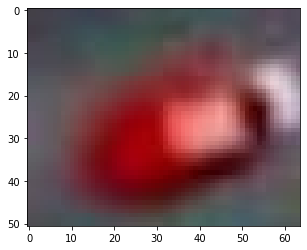

In [18]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# # Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

# analyze_url = endpoint + "vision/v3.0/analyze"

# # Set image_path to the local path of an image that you want to analyze.
# # Sample images are here, if needed:
# # https://github.com/Azure-Samples/cognitive-services-sample-data-files/tree/master/ComputerVision/Images
# image_path = "C:/Documents/ImageToAnalyze.jpg"
image_path = "./crop.jpg"


# Read the image into a byte array
image_data = open(image_path, "rb").read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {'visualFeatures': 'Color'}
response = requests.post(
    analyze_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
# analysis = response.json()
# print(analysis)
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))
# image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
# plt.axis("off")
# _ = plt.title(image_caption, size="x-large", y=-0.1)

## Playground 2


In [13]:
from azure.storage.blob import BlobServiceClient, ContainerClient

blob_service_client = BlobServiceClient.from_connection_string("DefaultEndpointsProtocol=https;AccountName=ckahrsmantechstorage;AccountKey=FUjBTCqAW6pRv0u+004Hc6eXfh14ly26ZdgK6sVfugEhIMeaUY1fbgDbs6aJp6a77K4ZJrbsdaqLhSEMJTDqTg==;EndpointSuffix=core.windows.net")
all_containers = blob_service_client.list_containers(include_metadata=True)
for container in all_containers:
    print(container['name'], container['metadata'])
    container_client = blob_service_client.get_container_client(container['name'])
    generator = container_client.list_blobs()

    #code below lists all the blobs in the container and downloads them one after another
    for blob in generator:
        print("   " + blob.name)

4bab
   chatapp/.git/objects/0e/c65974492d99a00fcef6820b68526bf1b08a42
   chatapp/.git/objects/0f/9f820ef6e5f21042efd0e9dc18d097388d7207
   chatapp/.git/objects/0f/ac90573dbd77c7eacb941e09db9144045e62bd
   chatapp/.git/objects/0f/db4ec4e91090876dc3fbf207049b521fa0dd73
   chatapp/.git/objects/10/26e63a63d8c4d20565c3bcf7fcca6f5faf765a
   chatapp/.git/objects/10/4b033281fa9ba2d3e66d1abe2b0358fc39607d
   chatapp/.git/objects/10/4fa5ef299a9944c3754b4f8a8bc9ed7c9d6204
   chatapp/.git/objects/10/c4b528d996d23a1319e3fed755aef0e6da2eb9
   chatapp/.git/objects/10/e65303b23ba366fe15ee9ad6b43f3894334f79
   chatapp/.git/objects/11/0757c7e7875a2e7612508d6c46b8d68c0b0cf4
   chatapp/.git/objects/11/696fdbd161f672b20ae18f6a789c7c7dd0dc98
   chatapp/.git/objects/12/05c618686fbb0e28bb9f61a782d7be790d1163
   chatapp/.git/objects/12/1edd93056f57c7717e6e48e2d7432cfc18ada4
   chatapp/.git/objects/12/21ceeaebd10ad203328b652f21f8902bcd9422
   chatapp/.git/objects/12/66ce05c6f4fddeec7f40a00ad4d2d85f531552
   ch

In [16]:
# Create a blob client using the local file name as the name for the blob
blob_client = blob_service_client.get_blob_client(container='satimages', blob='finaldata.json')



# Upload the created file
with open("finaldata.json", "rb") as data:
    blob_client.upload_blob(data)

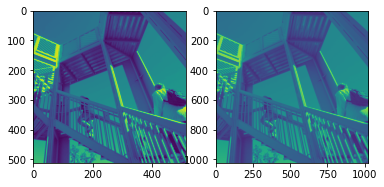

In [12]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, 2.0)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

In [13]:
ascent

array([[ 83,  83,  83, ..., 117, 117, 117],
       [ 82,  82,  83, ..., 117, 117, 117],
       [ 80,  81,  83, ..., 117, 117, 117],
       ...,
       [178, 178, 178, ...,  57,  59,  57],
       [178, 178, 178, ...,  56,  57,  57],
       [178, 178, 178, ...,  57,  57,  58]])

In [19]:
np.asarray(im.convert('L'))

array([[  7,   3,   8, ..., 149, 153, 155],
       [  2,   2,  13, ..., 152, 154, 156],
       [  5,  14,  41, ..., 155, 156, 157],
       ...,
       [146, 146, 144, ...,  99,  95,  79],
       [140, 134, 124, ...,  96,  98,  93],
       [109, 111, 114, ...,  86,  92, 100]], dtype=uint8)